In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Diretório onde estão armazenadas as imagens inteiras
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [4]:
def load_image(image_path, target_size=(224, 224)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normaliza a imagem para a faixa [0, 1]
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [5]:
# Caminho para o arquivo de IDs das imagens com fundo dark
ids_dark = r'C:\Users\bruna\OneDrive\Microbialdataset\dark_images_ids.txt'

# Carregar IDs do grupo de treinamento de um arquivo de texto
with open(ids_dark, 'r') as file:
    ids = [line.strip() for line in file.readlines()]

In [6]:
# Dividir os IDs em treinamento e validação (80% para treinamento e 20% para validação)
split_index = int(len(ids) * 0.8)
train_ids = ids[:split_index]
val_ids = ids[split_index:]

In [7]:
# Definir o número de classes
num_classes = 5

# Função para mapear IDs para rótulos automaticamente
def map_id_to_label(image_id):
    # Exemplo de mapeamento: hash do ID mod num_classes
    return int(image_id) % num_classes

In [8]:
# Função para carregar e redimensionar a imagem
def load_image(image_path, target_size=(224, 224)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normaliza a imagem para a faixa [0, 1]
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [9]:
# Função para carregar as imagens e as labels
def load_data(image_id, image_dir, target_size=(224, 224)):
    image_path = os.path.join(image_dir, f'{image_id}.jpg')  # Ajustar conforme necessário
    image = load_image(image_path, target_size)
    if image is None:
        return None, None
    
    # Usar a função de mapeamento para obter o rótulo
    label = map_id_to_label(image_id)
    
    return image, label

In [11]:
def data_generator(ids, image_dir, target_size=(224, 224)):
    for image_id in ids:
        image, label = load_data(image_id, image_dir, target_size)
        if image is not None and label is not None:
            yield image, label

In [15]:
def preprocess(image, label):
    image = tf.image.per_image_standardization(image)
    label = tf.cast(label, dtype=tf.int32)  # Garantir que label é do tipo int32
    label = tf.one_hot(label, depth=num_classes)  # Ajustar para o número de classes
    return image, label

In [16]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_ids, image_dir),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_ids, image_dir),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

# Aplicar preprocessamento
train_dataset = train_dataset.map(preprocess).batch(32).shuffle(buffer_size=len(train_ids))
val_dataset = val_dataset.map(preprocess).batch(32)


In [17]:
# Verificar o output do data generator
for image, label in data_generator(train_ids[:5], image_dir):
    print(f"Imagem shape: {image.shape}, Label: {label}")

Imagem shape: (224, 224, 3), Label: 0
Imagem shape: (224, 224, 3), Label: 1
Imagem shape: (224, 224, 3), Label: 2
Imagem shape: (224, 224, 3), Label: 3
Imagem shape: (224, 224, 3), Label: 4


In [18]:
for image, label in train_dataset.take(1):
    print(f'Imagem shape após preprocessamento: {image.numpy().shape}')
    print(f'Label após preprocessamento: {label.numpy()}')

Imagem shape após preprocessamento: (32, 224, 224, 3)
Label após preprocessamento: [[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [19]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

# Carregar o modelo InceptionV3 pré-treinado, excluindo a última camada
base_model = InceptionV3(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

In [20]:
# Congelar as camadas do modelo base
base_model.trainable = False

In [ ]:
# Escolher até onde descongelar as camadas
fine_tune_at = 100  # número de camadas a serem descongeladas

# Congelar todas as camadas até o fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [21]:
# Adicionar as próprias camadas no topo do modelo base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),  # Adicione um dropout para ajudar a prevenir overfitting
    layers.Dense(5, activation='softmax')  # Ajustar para o número de classes
])

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Definição de callbacks (verifique se não há argumentos não suportados)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model_checkpoint.h5',  # ou '.tf' para o formato SavedModel
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1
    )
]

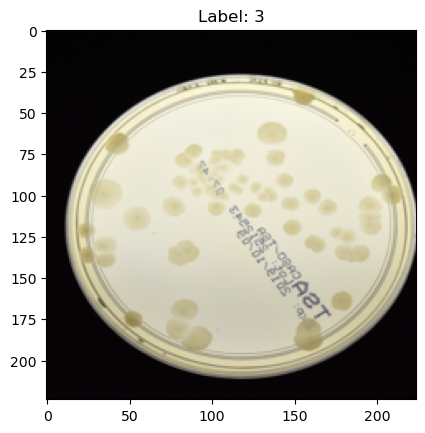

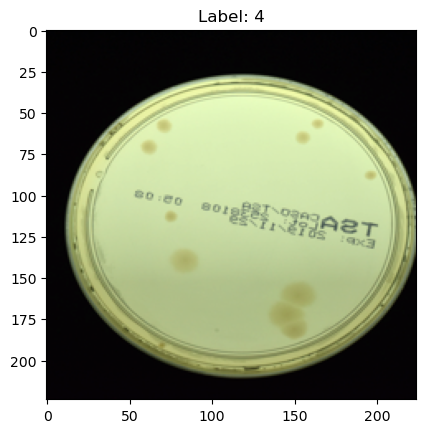

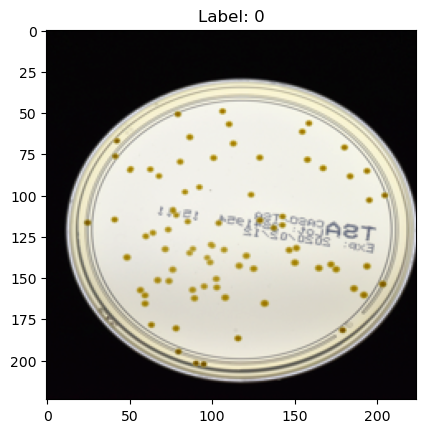

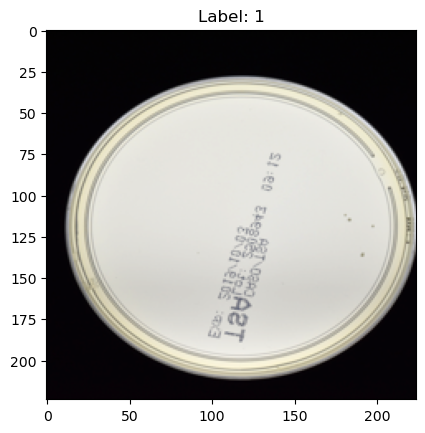

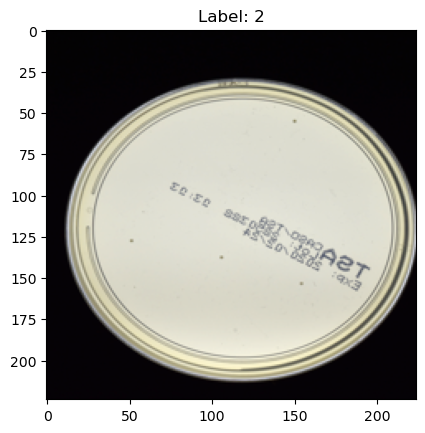

In [52]:
# Verificar algumas imagens e rótulos do conjunto de treinamento
for image_batch, label_batch in train_dataset.take(1):
    for i in range(5):  # Exibir 5 imagens do lote
        image = image_batch[i]  # Obtém uma imagem do lote
        label = label_batch[i]  # Obtém o respectivo rótulo do lote
        # Reescala a imagem para o intervalo [0, 1] para a visualização
        image_rescaled = (image.numpy() - image.numpy().min()) / (image.numpy().max() - image.numpy().min())
        plt.imshow(image_rescaled)  # Exibe a imagem reescalada
        plt.title(f'Label: {np.argmax(label.numpy())}')  # Corrigido para mostrar a classe correta
        plt.show()

In [ ]:
# Treinamento do modelo
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
    242/Unknown - 1861s 960ms/step - loss: 1.6105 - accuracy: 0.1995
Epoch 1: val_loss improved from inf to 1.61318, saving model to model_checkpoint.h5


C:\Users\bruna\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 79754s 324s/step - loss: 1.6105 - accuracy: 0.1995 - val_loss: 1.6132 - val_accuracy: 0.1943
Epoch 2/10
242/242 [==============================] - ETA: 0s - loss: 1.6099 - accuracy: 0.1991
Epoch 2: val_loss improved from 1.61318 to 1.61106, saving model to model_checkpoint.h5
242/242 [==============================] - 2318s 3s/step - loss: 1.6099 - accuracy: 0.1991 - val_loss: 1.6111 - val_accuracy: 0.1912
Epoch 3/10
242/242 [==============================] - ETA: 0s - loss: 1.6096 - accuracy: 0.2015
Epoch 3: val_loss improved from 1.61106 to 1.60983, saving model to model_checkpoint.h5
242/242 [==============================] - 2406s 3s/step - loss: 1.6096 - accuracy: 0.2015 - val_loss: 1.6098 - val_accuracy: 0.2036
Epoch 4/10
242/242 [==============================] - ETA: 0s - loss: 1.6094 - accuracy: 0.2086
Epoch 4: val_loss did not improve from 1.60983
242/242 [==============================] - 2388s 3s/step - loss: 1.6094 - accuracy: 0.2

In [ ]:
loss, accuracy = model.evaluate(val_dataset)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
# Visualizando a perda e a acurácia
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()